## CS310 Natural Language Processing
## Assignment 3 (part 2). Named Entity Recognition with Bi-LSTM

**Total points**: 30 + 20 bonus points

In this assignment, you will train a bidirectional LSTM model on the CoNLL2003 English named entity recognition task set and evaluate its performance.

For the bonus questions, submit them as separate notebook files.

### 0. Import Necessary Libraries

In [1]:
### 0. Import Necessary Libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import random

# 设置随机种子以确保可重复性
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
# 设置GPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "5,6,7"  # 指定使用GPU 4-7

# 检查CUDA是否可用
print(f"CUDA是否可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"当前使用的GPU设备: {os.environ['CUDA_VISIBLE_DEVICES']}")
    print(f"可用的GPU数量: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("警告：没有检测到可用的GPU！")

# 设置默认设备
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {DEVICE}")

# 确保模型和数据都在GPU上
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)
    

CUDA是否可用: True
当前使用的GPU设备: 5,6,7
可用的GPU数量: 3
GPU 0: NVIDIA GeForce RTX 4090 D
GPU 1: NVIDIA GeForce RTX 4090 D
GPU 2: NVIDIA GeForce RTX 4090 D
使用的设备: cuda


In [2]:
class Vocabulary:
    def __init__(self, min_freq=1):
        self.min_freq = min_freq
        self.word2idx = {'<PAD>': 0, '<UNK>': 1, '<EOS>': 2}
        self.idx2word = {0: '<PAD>', 1: '<UNK>', 2: '<EOS>'}
        self.word_freq = Counter()
        
    def build_vocab(self, text):
        # 统计词频
        self.word_freq.update(text)
        
        # 只保留频率大于等于min_freq的词
        idx = len(self.word2idx)
        for word, freq in self.word_freq.items():
            if freq >= self.min_freq and word not in self.word2idx:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1
                
    def __len__(self):
        return len(self.word2idx)

class TextDataset(Dataset):
    def __init__(self, words, vocab, seq_length):
        self.words = words
        self.vocab = vocab
        self.seq_length = seq_length
        
        # 将单词转换为索引
        self.word_indices = [vocab.word2idx.get(word, vocab.word2idx['<UNK>']) 
                           for word in words]
        
    def __len__(self):
        return max(0, len(self.word_indices) - self.seq_length)
    
    def __getitem__(self, idx):
        # 获取输入序列
        input_seq = self.word_indices[idx:idx + self.seq_length]
        # 获取目标序列（向后移动一个位置）
        target_seq = self.word_indices[idx + 1:idx + self.seq_length + 1]
        
        return (torch.LongTensor(input_seq), 
                torch.LongTensor(target_seq))

### 1. Build the Model

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, 
                          batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
    def forward(self, x, hidden=None):
        # x shape: [batch_size, seq_len]
        batch_size = x.size(0)
        
        if hidden is None:
            hidden = self.init_hidden(batch_size)
            
        # 词嵌入
        embedded = self.dropout(self.embedding(x))
        # embedded shape: [batch_size, seq_len, embedding_dim]
        
        # LSTM前向传播
        output, hidden = self.lstm(embedded, hidden)
        # output shape: [batch_size, seq_len, hidden_dim]
        
        # 应用dropout
        output = self.dropout(output)
        
        # 全连接层
        output = self.fc(output)
        # output shape: [batch_size, seq_len, vocab_size]
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters())
        return (weight.new_zeros(self.num_layers, batch_size, self.hidden_dim),
                weight.new_zeros(self.num_layers, batch_size, self.hidden_dim))

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs, device):
    train_losses = []
    test_perplexities = []
    best_perplexity = float('inf')
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            output, hidden = model(inputs)
            
            # 重塑输出和目标以计算损失
            output = output.view(-1, output.size(-1))
            targets = targets.view(-1)
            
            loss = criterion(output, targets)
            loss.backward()
            
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}/{len(train_loader)}, '
                      f'Loss: {loss.item():.4f}')
            
            train_losses.append(loss.item())
        
        # 评估模型
        model.eval()
        total_loss = 0
        total_words = 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                output, hidden = model(inputs)
                output = output.view(-1, output.size(-1))
                targets = targets.view(-1)
                
                loss = criterion(output, targets)
                total_loss += loss.item() * targets.size(0)
                total_words += targets.size(0)
        
        perplexity = np.exp(total_loss / total_words)
        test_perplexities.append(perplexity)
        
        print(f'Epoch: {epoch+1}/{num_epochs}, Test Perplexity: {perplexity:.4f}')
        
        # 保存最佳模型
        if perplexity < best_perplexity:
            best_perplexity = perplexity
            torch.save(model.state_dict(), 'best_lstm_model.pth')
    
    return train_losses, test_perplexities

def generate_text(model, vocab, prefix, max_length=50, temperature=1.0):
    model.eval()
    words = prefix.lower().split()
    device = next(model.parameters()).device
    
    # 转换前缀词为索引
    input_indices = [vocab.word2idx.get(word, vocab.word2idx['<UNK>']) for word in words]
    input_tensor = torch.LongTensor([input_indices]).to(device)
    
    with torch.no_grad():
        hidden = None
        generated_words = words.copy()
        
        for _ in range(max_length):
            output, hidden = model(input_tensor, hidden)
            
            # 获取最后一个时间步的预测
            word_weights = output[0, -1].div(temperature).exp()
            word_idx = torch.multinomial(word_weights, 1)[0]
            
            # 将生成的词添加到结果中
            generated_word = vocab.idx2word[word_idx.item()]
            generated_words.append(generated_word)
            
            # 准备下一个输入
            input_tensor = torch.LongTensor([[word_idx]]).to(device)
            
            if generated_word == '<EOS>':
                break
    
    return ' '.join(generated_words)

def load_and_preprocess_data(file_path, seq_length=35):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read().lower()
    
    # 使用简单的空格分词而不是NLTK
    words = text.split()
    # 或者使用更细致的分词规则
    # words = [word for word in text.replace('\n', ' ').replace('\t', ' ').split(' ') if word.strip()]
    
    # 构建词汇表
    vocab = Vocabulary(min_freq=2)
    vocab.build_vocab(words)
    
    # 划分训练集和测试集
    split_idx = int(len(words) * 0.9)
    train_words = words[:split_idx]
    test_words = words[split_idx:]
    
    # 创建数据集
    train_dataset = TextDataset(train_words, vocab, seq_length)
    test_dataset = TextDataset(test_words, vocab, seq_length)
    
    return train_dataset, test_dataset, vocab

### 2. Train and Evaluate

Epoch: 1/10, Batch: 0/956, Loss: 9.7699
Epoch: 1/10, Batch: 100/956, Loss: 6.7350
Epoch: 1/10, Batch: 200/956, Loss: 6.1806
Epoch: 1/10, Batch: 300/956, Loss: 5.9743
Epoch: 1/10, Batch: 400/956, Loss: 5.7891
Epoch: 1/10, Batch: 500/956, Loss: 5.5789
Epoch: 1/10, Batch: 600/956, Loss: 5.3926
Epoch: 1/10, Batch: 700/956, Loss: 5.3031
Epoch: 1/10, Batch: 800/956, Loss: 5.1712
Epoch: 1/10, Batch: 900/956, Loss: 5.1089
Epoch: 1/10, Test Perplexity: 253.6364
Epoch: 2/10, Batch: 0/956, Loss: 5.0408
Epoch: 2/10, Batch: 100/956, Loss: 4.9701
Epoch: 2/10, Batch: 200/956, Loss: 4.9104
Epoch: 2/10, Batch: 300/956, Loss: 4.8917
Epoch: 2/10, Batch: 400/956, Loss: 4.8625
Epoch: 2/10, Batch: 500/956, Loss: 4.7889
Epoch: 2/10, Batch: 600/956, Loss: 4.7292
Epoch: 2/10, Batch: 700/956, Loss: 4.7115
Epoch: 2/10, Batch: 800/956, Loss: 4.6791
Epoch: 2/10, Batch: 900/956, Loss: 4.6532
Epoch: 2/10, Test Perplexity: 271.6022
Epoch: 3/10, Batch: 0/956, Loss: 4.6269
Epoch: 3/10, Batch: 100/956, Loss: 4.6188
Epoc

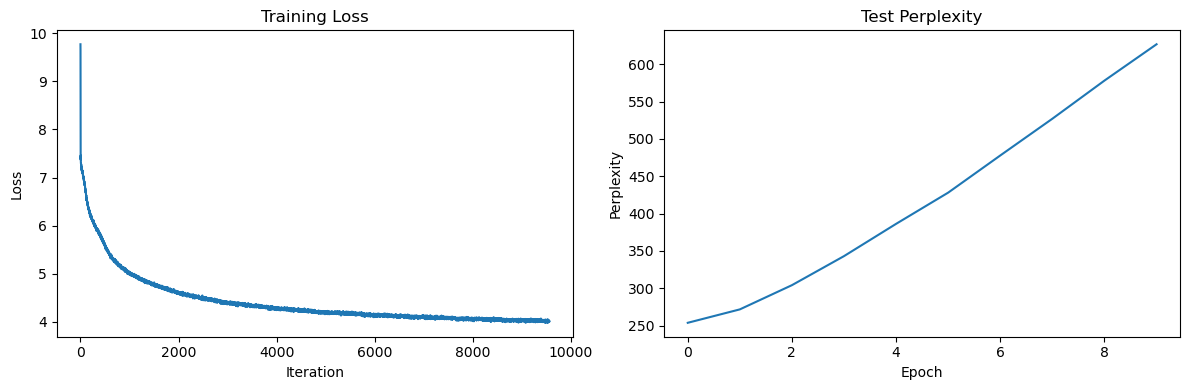

In [6]:
# 设置参数
EMBEDDING_DIM = 300  # 增加嵌入维度
HIDDEN_DIM = 512    # 增加隐藏层维度
NUM_LAYERS = 2
BATCH_SIZE = 1024
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
SEQUENCE_LENGTH = 35
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 加载数据
file_path = '/home/hljiang/CS310-Natural_Language_Processing/assignments/A3/Harry_Potter_all_books_preprocessed.txt'
train_dataset, test_dataset, vocab = load_and_preprocess_data(file_path, SEQUENCE_LENGTH)

# 创建数据加载器
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 初始化模型
model = LSTMModel(len(vocab), EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 训练模型
train_losses, test_perplexities = train_model(
    model, train_loader, test_loader, criterion, optimizer, 
    NUM_EPOCHS, DEVICE
)

# 生成示例文本
test_prefixes = [
    "Harry looked at",
    "The castle was",
    "Hermione said",
    "Ron couldn't",
    "Dumbledore smiled"
]

print("\n生成的文本样例:")
for prefix in test_prefixes:
    generated = generate_text(model, vocab, prefix)
    print(f"\n前缀: {prefix}")
    print(f"生成: {generated}")

# 绘制训练损失和测试困惑度曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(test_perplexities)
plt.title('Test Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Perplexity')

plt.tight_layout()
# 保存图表
plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
plt.show()



正在下载GloVe预训练词向量...
在预训练词向量中找到的词数: 13727/17544

开始训练使用预训练词向量的模型...
Epoch: 1/10, Batch: 0/956, Loss: 9.7771
Epoch: 1/10, Batch: 100/956, Loss: 7.0841
Epoch: 1/10, Batch: 200/956, Loss: 6.6865
Epoch: 1/10, Batch: 300/956, Loss: 6.3739
Epoch: 1/10, Batch: 400/956, Loss: 6.1636
Epoch: 1/10, Batch: 500/956, Loss: 5.9351
Epoch: 1/10, Batch: 600/956, Loss: 5.5987
Epoch: 1/10, Batch: 700/956, Loss: 5.3406
Epoch: 1/10, Batch: 800/956, Loss: 5.1488
Epoch: 1/10, Batch: 900/956, Loss: 5.0409
Epoch: 1/10, Test Perplexity: 234.2481
Epoch: 2/10, Batch: 0/956, Loss: 4.9371
Epoch: 2/10, Batch: 100/956, Loss: 4.8953
Epoch: 2/10, Batch: 200/956, Loss: 4.8234
Epoch: 2/10, Batch: 300/956, Loss: 4.7725
Epoch: 2/10, Batch: 400/956, Loss: 4.6907
Epoch: 2/10, Batch: 500/956, Loss: 4.6838
Epoch: 2/10, Batch: 600/956, Loss: 4.6223
Epoch: 2/10, Batch: 700/956, Loss: 4.5864
Epoch: 2/10, Batch: 800/956, Loss: 4.5439
Epoch: 2/10, Batch: 900/956, Loss: 4.5157
Epoch: 2/10, Test Perplexity: 252.2175
Epoch: 3/10, Batch: 

/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 36845 (\N{CJK UNIFIED IDEOGRAPH-8FED}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 20195 (\N{CJK UNIFIED IDEOGRAPH-4EE3}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 27425 (\N{CJK UNIFIED IDEOGRAPH-6B21}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_3200859/234503075.py:61: UserWarning: Glyph 35757 (\N{CJK UNIFIED IDEOGRAPH-8BAD}) missing from current font.

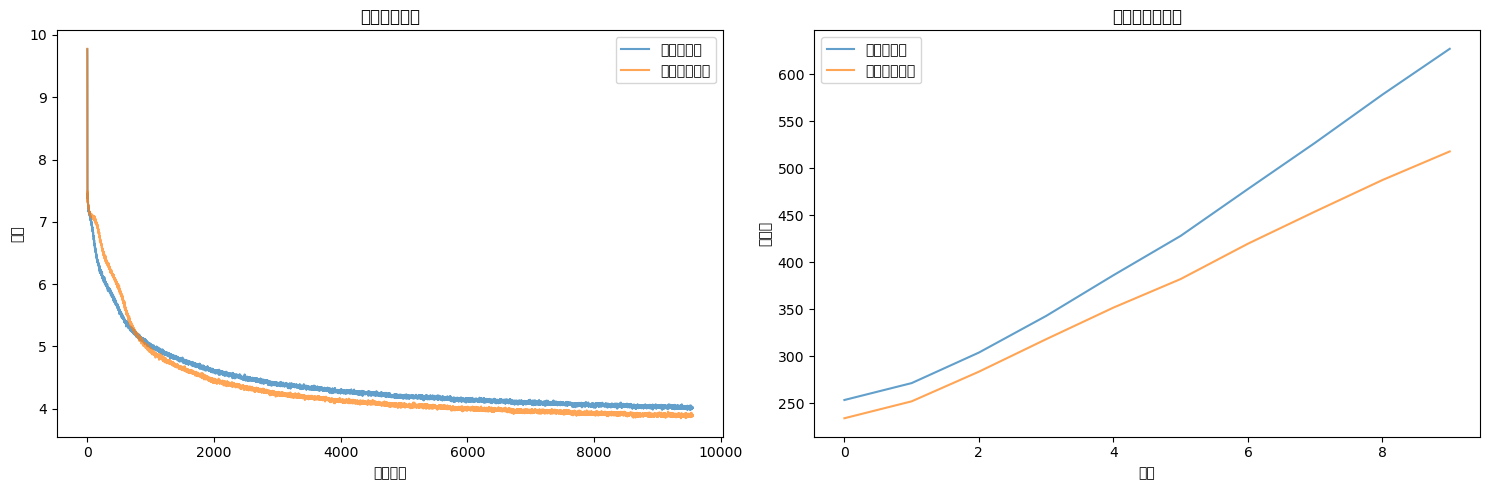


最终测试集困惑度对比:
随机初始化: 626.78
预训练词向量: 517.73

预训练词向量模型表现更好，保存为best_model_pretrained.pth


In [7]:
# 导入必要的库
import gensim.downloader as api
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

print("正在下载GloVe预训练词向量...")
glove_vectors = api.load('glove-wiki-gigaword-200')

def create_embedding_matrix(vocab, word_vectors, embedding_dim=200):
    embedding_matrix = np.zeros((len(vocab), embedding_dim))
    found_words = 0
    
    for word, idx in vocab.word2idx.items():
        try:
            embedding_matrix[idx] = word_vectors[word]
            found_words += 1
        except KeyError:
            # 对于不在预训练向量中的词，保持为零向量
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))
            
    print(f"在预训练词向量中找到的词数: {found_words}/{len(vocab)}")
    return embedding_matrix

# 使用预训练词向量初始化模型
model_pretrained = LSTMModel(len(vocab), 200, HIDDEN_DIM, NUM_LAYERS).to(DEVICE)
embedding_matrix = create_embedding_matrix(vocab, glove_vectors)
model_pretrained.embedding.weight.data.copy_(torch.FloatTensor(embedding_matrix))

# 训练带有预训练词向量的模型
criterion = nn.CrossEntropyLoss()
optimizer_pretrained = torch.optim.Adam(model_pretrained.parameters(), lr=LEARNING_RATE)

print("\n开始训练使用预训练词向量的模型...")
train_losses_pretrained, test_perplexities_pretrained = train_model(
    model_pretrained, train_loader, test_loader, criterion, 
    optimizer_pretrained, NUM_EPOCHS, DEVICE
)

# 绘制对比图
plt.figure(figsize=(15, 5))

# 绘制训练损失对比
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='随机初始化', alpha=0.7)
plt.plot(train_losses_pretrained, label='预训练词向量', alpha=0.7)
plt.title('训练损失对比')
plt.xlabel('迭代次数')
plt.ylabel('损失')
plt.legend()

# 绘制测试困惑度对比
plt.subplot(1, 2, 2)
plt.plot(test_perplexities, label='随机初始化', alpha=0.7)
plt.plot(test_perplexities_pretrained, label='预训练词向量', alpha=0.7)
plt.title('测试困惑度对比')
plt.xlabel('轮次')
plt.ylabel('困惑度')
plt.legend()

plt.tight_layout()
plt.show()

# 报告最终测试集困惑度
print("\n最终测试集困惑度对比:")
print(f"随机初始化: {test_perplexities[-1]:.2f}")
print(f"预训练词向量: {test_perplexities_pretrained[-1]:.2f}")

# 保存最佳模型
if test_perplexities_pretrained[-1] < test_perplexities[-1]:
    print("\n预训练词向量模型表现更好，保存为best_model_pretrained.pth")
    torch.save(model_pretrained.state_dict(), 'best_model_pretrained.pth')
else:
    print("\n随机初始化模型表现更好，保存为best_model_random.pth")
    torch.save(model.state_dict(), 'best_model_random.pth')